In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable
import tqdm

#try:
#    import cupy as cp
#    use_gpu = True
#except ImportError():
#    print("Not on GPU")
#    use_gpu = False

use_gpu = True

from stableemrifisher.fisher.stablederivatives import StableEMRIDerivative

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
    force_backend = 'cpu'
else:
    force_backend = 'gpu'
    pass #let the backend decide for itself.

startup


In [2]:
from few.waveform import FastSchwarzschildEccentricFlux

waveform_derivative = StableEMRIDerivative(waveform_class=FastSchwarzschildEccentricFlux,
                                          mode_selector_kwargs=dict(mode_selection_threshold=1e-5), 
                                          inspiral_kwargs=dict(err=1e-11, max_iter=10000))

In [3]:
waveform_derivative.waveform_generator.backend.uses_cupy

True

In [5]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 1.0
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = np.pi/4
Phi_theta0 = 0.0
Phi_r0 = 0.0

T = 0.1
dt = 10.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['m1','m2','a','p0','e0','xI0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_theta0','Phi_r0']

parameters = {}
for i in range(len(param_names)):
    parameters[param_names[i]] = pars_list[i]

param_to_vary = 'qS'

delta = 1e-5  #finite difference delta for the chosen paramete
order = 4 #order of finite-difference derivative
kind = "central" #kind of finite-difference derivative

der = waveform_derivative(T = T, dt = dt, 
                    parameters = parameters, 
                    param_to_vary = param_to_vary,
                    delta = delta,
                    order = order,
                    kind = kind,
                    )

if use_gpu:
    der = der.get()

0


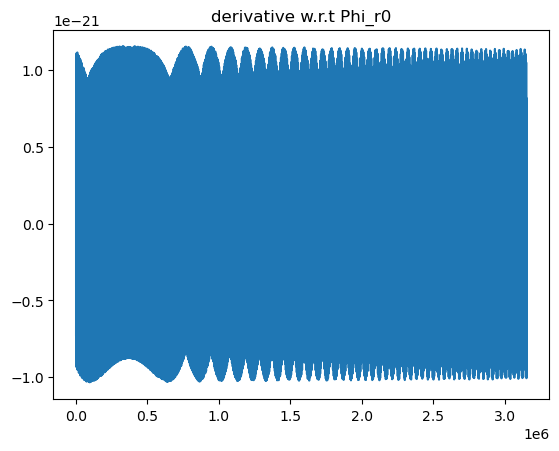

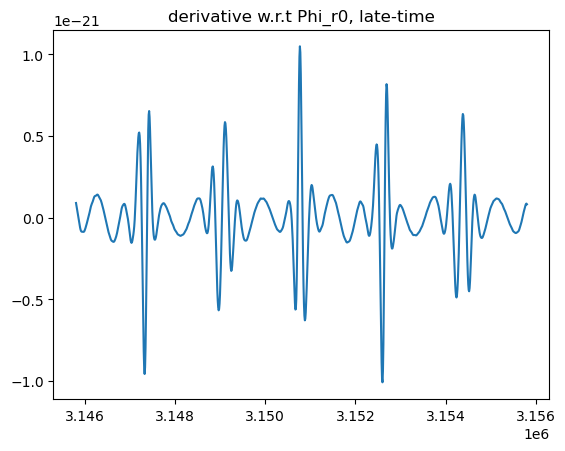

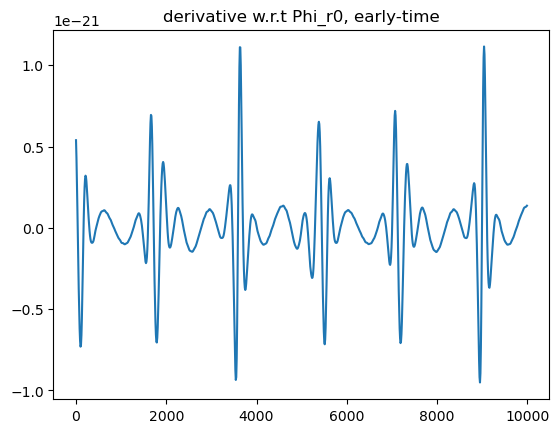

In [6]:
Npad = waveform_derivative.cache['Npad']

print(Npad)

if Npad == 0:
    Npad = 1
    
times = np.arange(len(der))*dt
plt.plot(times, der.real)
plt.title(f"derivative w.r.t {param_to_vary}")
plt.show()

times = np.arange(len(der))*dt
plt.plot(times[-Npad - 1000: - Npad], der.real[-Npad - 1000: -Npad])
plt.title(f"derivative w.r.t {param_to_vary}, late-time")
plt.show()

plt.plot(times[:1000], der.real[:1000])
plt.title(f"derivative w.r.t {param_to_vary}, early-time")
plt.show()

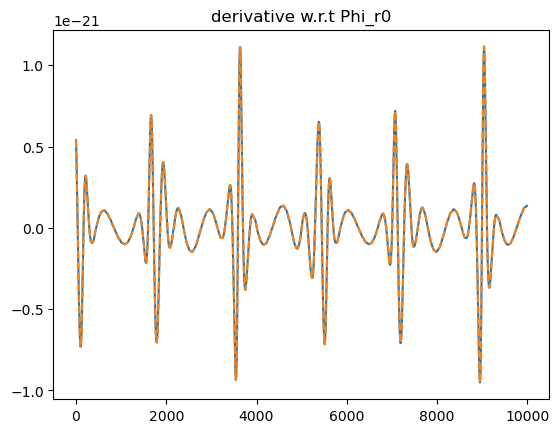

In [7]:
#compare with a different order and kind

order = 2 #order of finite-difference derivative
kind = "backward" #kind of finite-difference derivative

der_2nd = waveform_derivative(T = T, dt = dt, 
                    parameters = parameters, 
                    param_to_vary = param_to_vary,
                    delta = delta,
                    order = order,
                    kind = kind)

if use_gpu:
    der_2nd = der_2nd.get()

times = np.arange(len(der))*dt
plt.plot(times[:1000], der.real[:1000])
times = np.arange(len(der_2nd))*dt
plt.plot(times[:1000], der_2nd.real[:1000], '--')
plt.title(f"derivative w.r.t {param_to_vary}")
plt.show()

### Compare with finite difference derivative of the waveform itself

In [8]:
wave_gen_base = GenerateEMRIWaveform(
    FastSchwarzschildEccentricFlux,
    mode_selector_kwargs=dict(mode_selection = waveform_derivative.cache['mode_selection']), 
    inspiral_kwargs=dict(err=1e-11, max_iter=10000)
    )

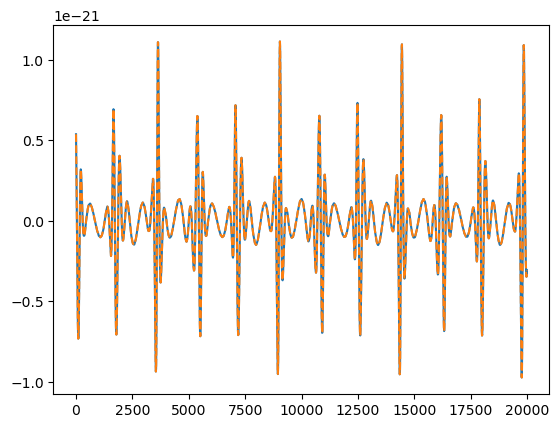

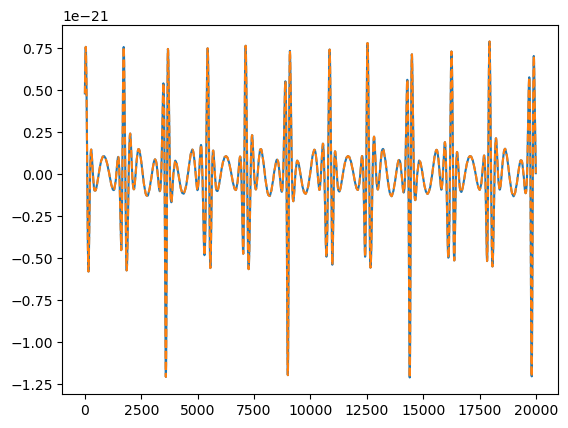

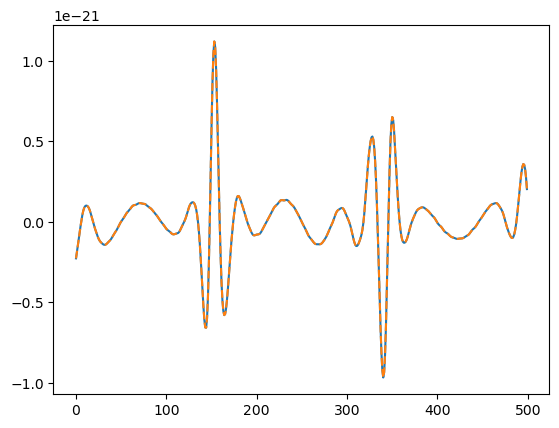

In [9]:
# compute the derivative manually
wavdelts = []

xp = waveform_derivative.xp

for delta in waveform_derivative.deltas:
    parameters_in = parameters.copy()
    parameters_in[param_to_vary] += delta
    wave = wave_gen_base(
        parameters_in['m1'],
        parameters_in['m2'],
        parameters_in['a'],
        parameters_in['p0'],
        parameters_in['e0'],
        parameters_in['xI0'],
        parameters_in['dist'],
        parameters_in['qS'],
        parameters_in['phiS'],
        parameters_in['qK'],
        parameters_in['phiK'],
        Phi_phi0 = parameters_in['Phi_phi0'],
        Phi_theta0 = parameters_in['Phi_theta0'],
        Phi_r0 = parameters_in['Phi_r0'],
        dt=dt, 
        T=T,
    )
    
    wave = xp.concatenate((wave[:-Npad],xp.zeros(Npad)), dtype = wave.dtype)
    
    wavdelts.append(wave)

wavdelts = xp.asarray(wavdelts) 

deriv_man = waveform_derivative._stencil(wavdelts, waveform_derivative.delta, waveform_derivative.order, waveform_derivative.kind)

if use_gpu:
    deriv_man = deriv_man.get()

plt.plot(times[:2000], der.real[0:2000])
plt.plot(times[:2000], deriv_man.real[0:2000], '--')
plt.show()

plt.plot(times[:2000], der.imag[0:2000])
plt.plot(times[:2000], deriv_man.imag[0:2000], '--')
plt.show()

plt.plot(der.real[20000:20500])
plt.plot(deriv_man.real[20000:20500], '--')
plt.show()

### Compare Fish_inv with 1D likelihood at the parameter point

In [10]:
from stableemrifisher.utils import inner_product, generate_PSD, padding
from tqdm import tqdm

wave = wave_gen_base(
        parameters['m1'],
        parameters['m2'],
        parameters['a'],
        parameters['p0'],
        parameters['e0'],
        parameters['xI0'],
        parameters['dist'],
        parameters['qS'],
        parameters['phiS'],
        parameters['qK'],
        parameters['phiK'],
        Phi_phi0 = parameters['Phi_phi0'],
        Phi_theta0 = parameters['Phi_theta0'],
        Phi_r0 = parameters['Phi_r0'],
        dt=dt, 
        T=T,
    )

wave = xp.concatenate((wave[:-Npad], xp.zeros(Npad)), dtype = wave.dtype)

wave_list = [wave.real, -wave.imag]
PSD = generate_PSD(wave_list, dt=dt, use_gpu=use_gpu)

In [11]:
wave.shape

(315582,)

In [12]:
def Fisher_1D(partialh):
    return inner_product(partialh, partialh, PSD = PSD, dt = dt, use_gpu=use_gpu)

der_list = [der.real, -der.imag]
F1D = Fisher_1D(der_list)
sigma1D = 1/np.sqrt(F1D)
print(f"sigma {param_to_vary}: ", sigma1D)

sigma Phi_r0:  0.0016249161368509914


In [13]:
def likelihood(h_inj, h_temp):
    delta = h_inj - h_temp
    delta = [delta.real, -delta.imag]
    return np.exp(-0.5 * inner_product(delta, delta, PSD = PSD, dt = dt, use_gpu=use_gpu))

N = 50

param_to_vary_range = np.linspace(parameters[param_to_vary] - 4 * sigma1D, parameters[param_to_vary] + 4 * sigma1D, N)

likes = []

for i in tqdm(range(N)):
    parameters_in = parameters.copy()
    parameters_in[param_to_vary] = param_to_vary_range[i]
    htemp = wave_gen_base(
        parameters_in['m1'],
        parameters_in['m2'],
        parameters_in['a'],
        parameters_in['p0'],
        parameters_in['e0'],
        parameters_in['xI0'],
        parameters_in['dist'],
        parameters_in['qS'],
        parameters_in['phiS'],
        parameters_in['qK'],
        parameters_in['phiK'],
        Phi_phi0 = parameters_in['Phi_phi0'],
        Phi_theta0 = parameters_in['Phi_theta0'],
        Phi_r0 = parameters_in['Phi_r0'],
        dt=dt, 
        T=T,
    )

    htemp = xp.concatenate((htemp[:-Npad], xp.zeros(Npad)), dtype = htemp.dtype)
    
    likes.append(likelihood(wave, htemp))

100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.61it/s]


In [14]:
wave.shape, der.shape

((315582,), (315582,))

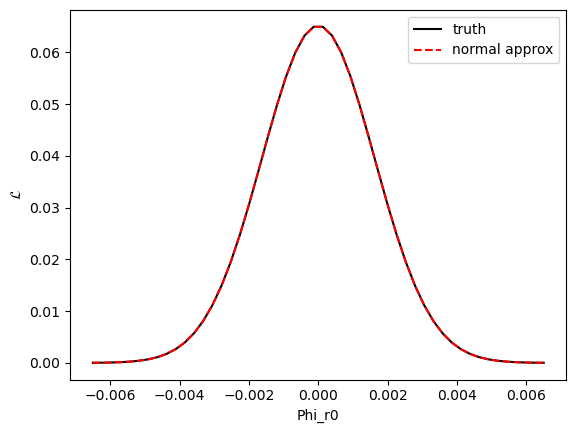

In [15]:
from scipy.stats import norm

normal_approx = norm.pdf(param_to_vary_range, loc = parameters[param_to_vary], scale = sigma1D)
normal_approx /= np.sum(normal_approx)
plt.plot(param_to_vary_range, likes/np.sum(likes), c='k', label='truth')
plt.plot(param_to_vary_range, normal_approx, c='r', label='normal approx', linestyle='--')
plt.legend()
plt.ylabel(r'$\mathcal{L}$')
plt.xlabel(param_to_vary)
plt.savefig(f'1D_like_vs_NA_{param_to_vary}.png', dpi = 300, bbox_inches='tight')
plt.show()

### potentially problematic parameters: 
#### 1) Failing derivative check (above construction v/s old method): m2 (most likely due to finite-difference truncation err. in the old method -> SEF can handle)
#### 2) Failing 1D like check: NONE (by eye)